<a href="https://colab.research.google.com/github/AidaAriafar/Selective-Amnesia-for-cVAEs/blob/main/afterLatentSpacePlot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

imports

In [ ]:
!pip install -q torch torchvision tensorboard tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, random, itertools, pathlib, datetime, json, os
from torch.utils.data import DataLoader, Subset, ConcatDataset, TensorDataset
from torchvision import datasets, transforms, utils
from torchvision.utils import make_grid, save_image
from tqdm.notebook import tqdm
import numpy as np
import copy
import pathlib
import matplotlib.pyplot as plt

configs

In [19]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

NUM_CLASSES = 10
LATENT_DIM = 40
BATCH_SIZE = 256
LR = 1e-3
EPOCHS = 25
N_FISHER_SAMPLES = 3000
EWC_LAMBDA = 500
NEG_LOSS_WEIGHT = 20.0
EPOCHS_UNL = 15
REPLAY_SAMPLES = 5000
GRAY_VALUE = 0.5

CKPT_DIR = pathlib.Path('checkpoints')
CKPT_DIR.mkdir(exist_ok=True)

cvae model

In [20]:
class CVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv = nn.Sequential(
            nn.Conv2d(1+NUM_CLASSES, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU()
        )
        self.enc_fc_mu = nn.Linear(7*7*64, LATENT_DIM)
        self.enc_fc_logvar = nn.Linear(7*7*64, LATENT_DIM)

        self.dec_fc = nn.Linear(LATENT_DIM+NUM_CLASSES, 7*7*64)
        self.dec_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid()
        )

    def encode(self, x, y_onehot):
        y_map = y_onehot.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, 28, 28)
        h = torch.cat([x, y_map], dim=1)
        h = self.enc_conv(h).flatten(1)
        return self.enc_fc_mu(h), self.enc_fc_logvar(h)

    def reparameterise(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y_onehot):
        h = self.dec_fc(torch.cat([z, y_onehot], dim=1)).view(-1, 64, 7, 7)
        return self.dec_conv(h)

    def forward(self, x, y):
        y_1h = F.one_hot(y, NUM_CLASSES).float()
        mu, logvar = self.encode(x, y_1h)
        z = self.reparameterise(mu, logvar)
        xr = self.decode(z, y_1h)
        return xr, mu, logvar


baseline training

In [21]:
transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST(root='.', train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root='.', train=False, download=True, transform=transform)
train_ld = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_ld  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
def vae_loss(xr, x, mu, logvar):
    recon = F.binary_cross_entropy(xr, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    beta = 0.5
    return (recon + (beta * kld)) / x.size(0)
model = CVAE().to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LR)

for epoch in range(1, EPOCHS+1):
    model.train()
    for x, y in tqdm(train_ld, desc=f'E{epoch}/{EPOCHS}', leave=False):
        x, y = x.to(DEVICE), y.to(DEVICE)
        xr, mu, logvar = model(x, y)
        loss = vae_loss(xr, x, mu, logvar)
        opt.zero_grad()
        loss.backward()
        opt.step()
    if epoch % 5 == 0:
        torch.save(model.state_dict(), CKPT_DIR/'vae_baseline.pt')
print('Baseline model complete.')

E1/25:   0%|          | 0/235 [00:00<?, ?it/s]

E2/25:   0%|          | 0/235 [00:00<?, ?it/s]

E3/25:   0%|          | 0/235 [00:00<?, ?it/s]

E4/25:   0%|          | 0/235 [00:00<?, ?it/s]

E5/25:   0%|          | 0/235 [00:00<?, ?it/s]

E6/25:   0%|          | 0/235 [00:00<?, ?it/s]

E7/25:   0%|          | 0/235 [00:00<?, ?it/s]

E8/25:   0%|          | 0/235 [00:00<?, ?it/s]

E9/25:   0%|          | 0/235 [00:00<?, ?it/s]

E10/25:   0%|          | 0/235 [00:00<?, ?it/s]

E11/25:   0%|          | 0/235 [00:00<?, ?it/s]

E12/25:   0%|          | 0/235 [00:00<?, ?it/s]

E13/25:   0%|          | 0/235 [00:00<?, ?it/s]

E14/25:   0%|          | 0/235 [00:00<?, ?it/s]

E15/25:   0%|          | 0/235 [00:00<?, ?it/s]

E16/25:   0%|          | 0/235 [00:00<?, ?it/s]

E17/25:   0%|          | 0/235 [00:00<?, ?it/s]

E18/25:   0%|          | 0/235 [00:00<?, ?it/s]

E19/25:   0%|          | 0/235 [00:00<?, ?it/s]

E20/25:   0%|          | 0/235 [00:00<?, ?it/s]

E21/25:   0%|          | 0/235 [00:00<?, ?it/s]

E22/25:   0%|          | 0/235 [00:00<?, ?it/s]

E23/25:   0%|          | 0/235 [00:00<?, ?it/s]

E24/25:   0%|          | 0/235 [00:00<?, ?it/s]

E25/25:   0%|          | 0/235 [00:00<?, ?it/s]

Baseline model complete.


experiment 1

In [22]:
FORGET_CLASSES = [5, 9, 6]
FORGET_STRING = "_".join(map(str, FORGET_CLASSES))
print(f"Forgetting classes {FORGET_CLASSES}")

Forgetting classes [5, 9, 6]


ex 2

In [15]:
FORGET_CLASSES = [1, 7, 8]
FORGET_STRING = "_".join(map(str, FORGET_CLASSES))
print(f"Forgetting classes {FORGET_CLASSES}")

--- STARTING EXPERIMENT 1: Forgetting classes [1, 7, 8] ---


ex 3

In [23]:
FORGET_CLASSES = [2, 3, 4]
FORGET_STRING = "_".join(map(str, FORGET_CLASSES))
print(f"--- STARTING EXPERIMENT 1: Forgetting classes {FORGET_CLASSES} ---")

--- STARTING EXPERIMENT 1: Forgetting classes [2, 3, 4] ---


fim

In [24]:
fisher = {n: torch.zeros_like(p) for n, p in model.named_parameters()}
model.eval()
cnt = 0
forget_indices = np.where(np.isin(train_ds.targets, FORGET_CLASSES))[0]
forget_set = Subset(train_ds, forget_indices)
forget_loader = DataLoader(forget_set, batch_size=BATCH_SIZE, shuffle=True)

for x, y in tqdm(forget_loader, desc='Fisher'):
    x, y = x.to(DEVICE), y.to(DEVICE)
    model.zero_grad()
    xr, mu, logvar = model(x, y)
    loss = vae_loss(xr, x, mu, logvar)
    loss.backward()
    for n, p in model.named_parameters():
        if p.grad is not None:
            fisher[n] += p.grad.detach().pow(2)
    cnt += 1
    if (cnt * x.size(0)) >= N_FISHER_SAMPLES:
        break

for n in fisher:
    if cnt > 0:
        fisher[n] /= cnt

BASELINE_STATE = {n: p.clone().detach() for n, p in model.named_parameters()}
print('Fisher calculation complete.')

Fisher:   0%|          | 0/71 [00:00<?, ?it/s]

Fisher calculation complete.


unlearning sess

In [25]:
model.eval()
replay_imgs, replay_lbls = [], []

kept_classes = torch.tensor([c for c in range(NUM_CLASSES) if c not in FORGET_CLASSES], device=DEVICE)

with torch.no_grad():
    g = torch.Generator(device=DEVICE).manual_seed(0)
    n_left = REPLAY_SAMPLES
    while n_left > 0:
        curr = min(BATCH_SIZE, n_left)
        y = kept_classes[torch.randint(0, len(kept_classes), (curr,), generator=g, device=DEVICE)]
        z = torch.randn(curr, LATENT_DIM, generator=g, device=DEVICE)
        imgs = model.decode(z, F.one_hot(y, NUM_CLASSES).float())
        replay_imgs.append(imgs.cpu())
        replay_lbls.append(y.cpu())
        n_left -= curr
replay_imgs = torch.cat(replay_imgs)
replay_lbls = torch.cat(replay_lbls)

replay_lbls_list = replay_lbls.tolist()
replay_dataset = list(zip(replay_imgs, replay_lbls_list))
retain_indices = np.where(np.isin(train_ds.targets, FORGET_CLASSES, invert=True))[0]
kept_real = Subset(train_ds, retain_indices)

unl_loader = DataLoader(ConcatDataset([kept_real, replay_dataset]),
                        batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

grey_target = torch.full((BATCH_SIZE, 1, 28, 28), GRAY_VALUE, device=DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LR * 0.5)
model.train()

for epoch in range(1, EPOCHS_UNL+1):
    for x, y in tqdm(unl_loader, desc=f'U{epoch}/{EPOCHS_UNL}', leave=False):
        x, y = x.to(DEVICE), y.to(DEVICE)
        xr, mu, logvar = model(x, y)
        loss = vae_loss(xr, x, mu, logvar)

        sa_loss = 0.
        for n, p in model.named_parameters():
            if n in fisher:
                sa_loss += (fisher[n] * (p - BASELINE_STATE[n]).pow(2)).sum()
        loss -= (EWC_LAMBDA / len(unl_loader.dataset)) * sa_loss

        with torch.no_grad():
            z_neg = torch.randn(x.size(0), LATENT_DIM, device=DEVICE)
            y_neg = torch.full((x.size(0),), np.random.choice(FORGET_CLASSES), dtype=torch.long, device=DEVICE)
            y1h_neg = F.one_hot(y_neg, NUM_CLASSES).float()
        x_neg = model.decode(z_neg, y1h_neg)
        loss += NEG_LOSS_WEIGHT * F.l1_loss(x_neg, grey_target.resize_as_(x_neg))

        opt.zero_grad()
        loss.backward()
        opt.step()

    if epoch % 5 == 0:
        torch.save(model.state_dict(), CKPT_DIR / f'vae_forget_{FORGET_STRING}.pt')

print(f'Unlearning done for {FORGET_CLASSES}')


U1/15:   0%|          | 0/184 [00:00<?, ?it/s]

U2/15:   0%|          | 0/184 [00:00<?, ?it/s]

U3/15:   0%|          | 0/184 [00:00<?, ?it/s]

U4/15:   0%|          | 0/184 [00:00<?, ?it/s]

U5/15:   0%|          | 0/184 [00:00<?, ?it/s]

U6/15:   0%|          | 0/184 [00:00<?, ?it/s]

U7/15:   0%|          | 0/184 [00:00<?, ?it/s]

U8/15:   0%|          | 0/184 [00:00<?, ?it/s]

U9/15:   0%|          | 0/184 [00:00<?, ?it/s]

U10/15:   0%|          | 0/184 [00:00<?, ?it/s]

U11/15:   0%|          | 0/184 [00:00<?, ?it/s]

U12/15:   0%|          | 0/184 [00:00<?, ?it/s]

U13/15:   0%|          | 0/184 [00:00<?, ?it/s]

U14/15:   0%|          | 0/184 [00:00<?, ?it/s]

U15/15:   0%|          | 0/184 [00:00<?, ?it/s]

Unlearning done for [2, 3, 4]


visual compar func

In [9]:
def show_comparison_grid(baseline_model_path, unlearned_model_path, title_string, rows=5, cols=4, seed=0):


    baseline_model = CVAE().to(DEVICE)
    baseline_model.load_state_dict(torch.load(baseline_model_path))

    unlearned_model = CVAE().to(DEVICE)
    unlearned_model.load_state_dict(torch.load(unlearned_model_path))

    labels = []
    for d in range(NUM_CLASSES):
        labels.extend([d, d])
    labels = labels[:rows*cols]
    y = torch.tensor(labels, device=DEVICE)

    g = torch.Generator(device=DEVICE).manual_seed(seed)
    z = torch.randn(len(labels), LATENT_DIM, generator=g, device=DEVICE)

    def decode_grid(model):
        model.eval()
        with torch.no_grad():
            imgs = model.decode(z, F.one_hot(y, NUM_CLASSES).float()).cpu()
        return make_grid(imgs, nrow=cols, pad_value=1)

    grid_left = decode_grid(baseline_model)
    grid_right = decode_grid(unlearned_model)

    fig, ax = plt.subplots(1, 2, figsize=(6, 6))
    fig.suptitle(f"Unlearning: {title_string}", fontsize=18)

    for a, grid, title in zip(ax, [grid_left, grid_right], ["Original", "Model after SA"]):
        a.imshow(grid.permute(1, 2, 0), cmap="gray")
        a.set_title(title, fontsize=16)
        a.axis("off")
    plt.show()

print("Comparison func defined.")

Comparison function `show_comparison_grid` is defined.


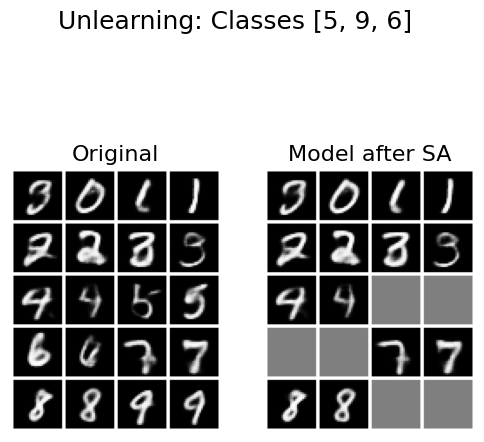

In [14]:
# ex 1 visual output
show_comparison_grid(
    baseline_model_path = CKPT_DIR / "vae_baseline.pt",
    unlearned_model_path = CKPT_DIR / f"vae_forget_{FORGET_STRING}.pt",
    title_string = f"Classes {FORGET_CLASSES}"
)
#the output is based on laten_dim=32, 4-7-8-9 look fine

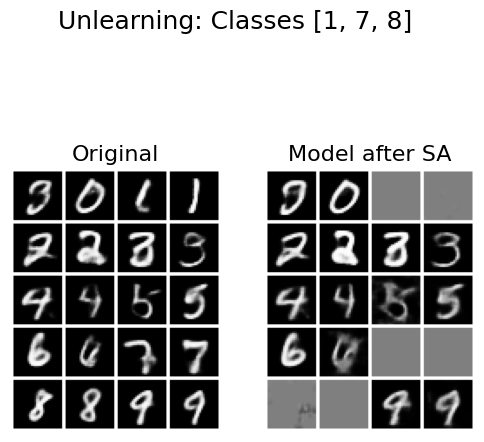

In [18]:
# ex 2 visual output
show_comparison_grid(
    baseline_model_path = CKPT_DIR / "vae_baseline.pt",
    unlearned_model_path = CKPT_DIR / f"vae_forget_{FORGET_STRING}.pt",
    title_string = f"Classes {FORGET_CLASSES}"
)

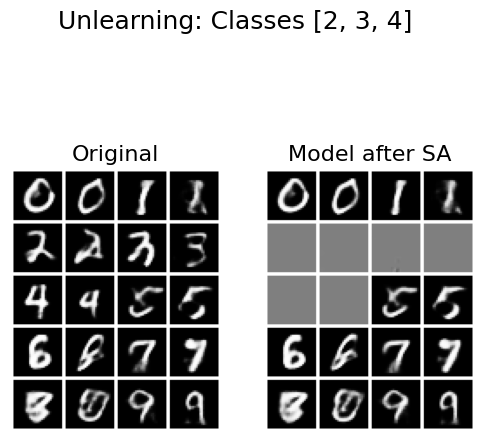

In [26]:
# ex 3 vis output$
show_comparison_grid(
    baseline_model_path = CKPT_DIR / "vae_baseline.pt",
    unlearned_model_path = CKPT_DIR / f"vae_forget_{FORGET_STRING}.pt",
    title_string = f"Classes {FORGET_CLASSES}"
)
#the output is based on laten_dim=40, 0-1-2-3-4-7-9 look fine

**task 2: plotting latent space**

In [27]:
!pip install -q scikit-learn

from sklearn.manifold import TSNE

In [32]:
def plot_latent_space(model, dataloader, title, forget_classes=[]):
    model.eval()
    all_mu = []
    all_labels = []
    with torch.no_grad():
        for x, y in tqdm(dataloader, desc="Encoding test set"):
            x, y = x.to(DEVICE), y.to(DEVICE)
            y_1h = F.one_hot(y, NUM_CLASSES).float()
            mu, _ = model.encode(x, y_1h)
            all_mu.append(mu.cpu())
            all_labels.append(y.cpu())
    all_mu = torch.cat(all_mu).numpy()
    all_labels = torch.cat(all_labels).numpy()
    if all_mu.shape[1] == 2:
        print("Latent dim is 2, plotting directly.")
        z_2d = all_mu
    else:
        print(f"Latent dim is {all_mu.shape[1]}, running t-SNE...")
        tsne = TSNE(n_components=2, init='pca', learning_rate='auto')
        z_2d = tsne.fit_transform(all_mu)
    plt.figure(figsize=(6, 6))
    retain_mask = ~np.isin(all_labels, forget_classes)
    plt.scatter(
        z_2d[retain_mask, 0], z_2d[retain_mask, 1],
        c=all_labels[retain_mask], cmap='tab10', s=10, alpha=0.5
    )
    forget_mask = np.isin(all_labels, forget_classes)
    plt.scatter(
        z_2d[forget_mask, 0], z_2d[forget_mask, 1],
        c='gray', s=10, alpha=1.0, label=f"Forgotten ({forget_classes})"
    )
    plt.colorbar(label='Digit Class')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_latent_traversal(model_path, n_steps=12, seed=0):
    model = CVAE().to(DEVICE)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    c_corners = torch.tensor([7, 9, 1, 6]).to(DEVICE)
    c_corners_1h = F.one_hot(c_corners, NUM_CLASSES).float()
    z_corners = []
    g = torch.Generator(device=DEVICE).manual_seed(seed)
    with torch.no_grad():
        for c in c_corners:
            idx = np.random.choice(np.where(train_ds.targets == c.item())[0])
            x, y = train_ds[idx]
            x, y = x.unsqueeze(0).to(DEVICE), torch.tensor([y]).to(DEVICE)
            y_1h = F.one_hot(y, NUM_CLASSES).float()
            mu, _ = model.encode(x, y_1h)
            z_corners.append(mu)
    z_corners = torch.cat(z_corners)
    z_top = torch.lerp(z_corners[0], z_corners[1], torch.linspace(0, 1, n_steps).to(DEVICE).unsqueeze(1))
    z_bot = torch.lerp(z_corners[2], z_corners[3], torch.linspace(0, 1, n_steps).to(DEVICE).unsqueeze(1))
    all_z = []
    for i in range(n_steps):
        z_col = torch.lerp(z_top[i], z_bot[i], torch.linspace(0, 1, n_steps).to(DEVICE).unsqueeze(1))
        all_z.append(z_col)
    all_z = torch.stack(all_z).view(-1, LATENT_DIM)
    c_top = torch.lerp(c_corners_1h[0], c_corners_1h[1], torch.linspace(0, 1, n_steps).to(DEVICE).unsqueeze(1))
    c_bot = torch.lerp(c_corners_1h[2], c_corners_1h[3], torch.linspace(0, 1, n_steps).to(DEVICE).unsqueeze(1))
    all_c = []
    for i in range(n_steps):
        c_col = torch.lerp(c_top[i], c_bot[i], torch.linspace(0, 1, n_steps).to(DEVICE).unsqueeze(1))
        all_c.append(c_col)
    all_c = torch.stack(all_c).view(-1, NUM_CLASSES)
    with torch.no_grad():
        generated_images = model.decode(all_z, all_c).cpu()
    grid = make_grid(generated_images, nrow=n_steps, padding=1)
    plt.figure(figsize=(6, 6))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title("Latent Space 2D Traversal", fontsize=12)
    plt.axis("off")
    plt.show()

print("visualization funcs defined")

Latent space visualization functions are defined.


Loading models for plotting...

--- Generating Latent Space Plots for the last unlearning experiment (Classes: [2, 3, 4]) ---


Encoding test set:   0%|          | 0/40 [00:00<?, ?it/s]

Latent dim is 40, running t-SNE...


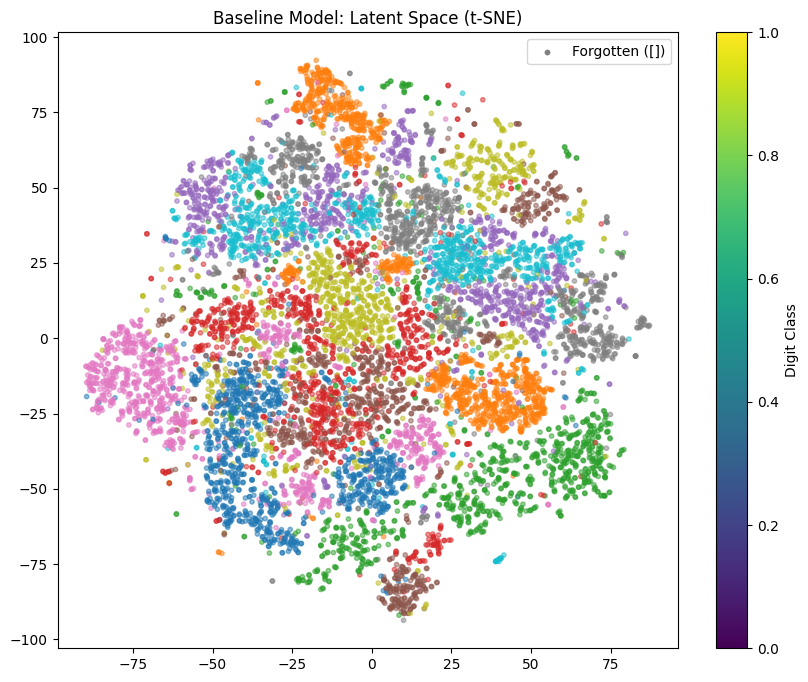

Encoding test set:   0%|          | 0/40 [00:00<?, ?it/s]

Latent dim is 40, running t-SNE...


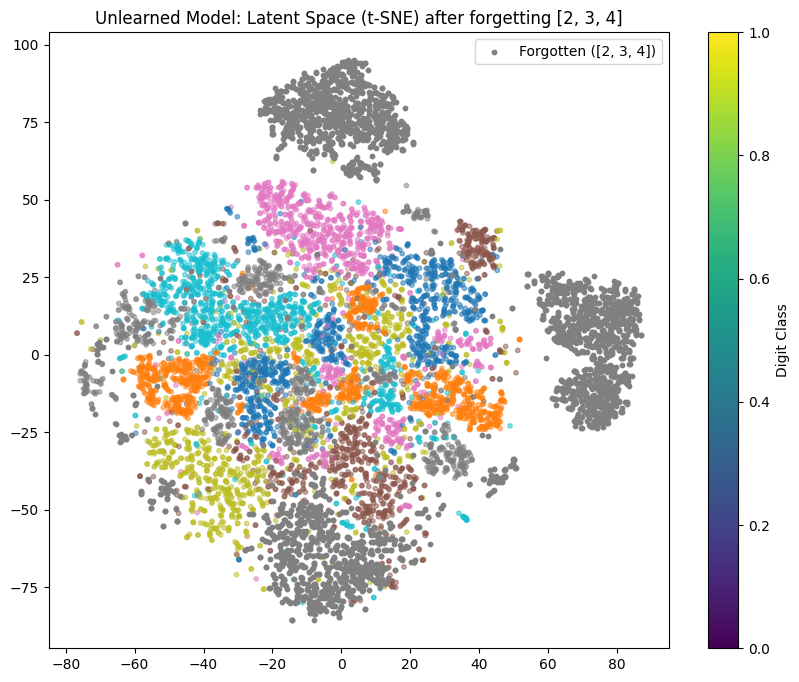

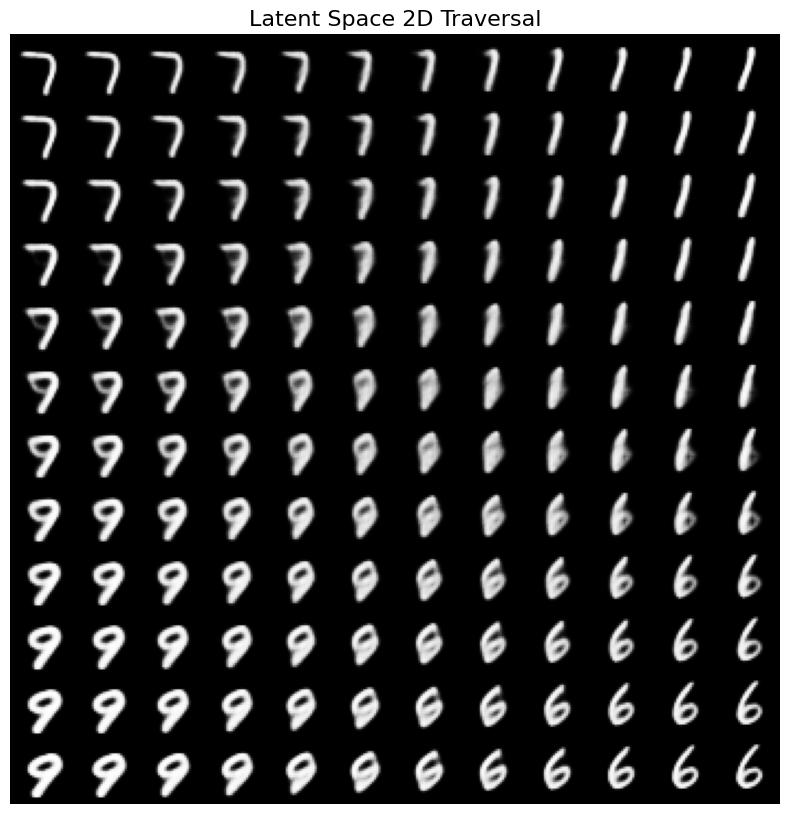

In [33]:
FORGET_CLASSES_LAST_EXP = [2, 3, 4]
FORGET_STRING_LAST_EXP = "_".join(map(str, FORGET_CLASSES_LAST_EXP))

LAST_UNLEARNED_MODEL_PATH = CKPT_DIR / f'vae_forget_{FORGET_STRING_LAST_EXP}.pt'
BASELINE_MODEL_PATH = CKPT_DIR / "vae_baseline.pt"

print("Loading models")
baseline_model_loaded = CVAE().to(DEVICE)
baseline_model_loaded.load_state_dict(torch.load(BASELINE_MODEL_PATH))

last_unlearned_model_loaded = CVAE().to(DEVICE)
last_unlearned_model_loaded.load_state_dict(torch.load(LAST_UNLEARNED_MODEL_PATH))


print(f"Latent Space Plots for(Classes: {FORGET_CLASSES_LAST_EXP})")

plot_latent_space(
    model = baseline_model_loaded,
    dataloader = test_ld,
    title = "Latent Space (t-SNE) for baseline model",
    forget_classes = []
)

plot_latent_space(
    model = last_unlearned_model_loaded,
    dataloader = test_ld,
    title = f"Latent Space (t-SNE) after forgetting {FORGET_CLASSES_LAST_EXP} for unlearned Model: ",
    forget_classes = FORGET_CLASSES_LAST_EXP
)

plot_latent_traversal(
    model_path = LAST_UNLEARNED_MODEL_PATH
)